# Housing Prices


### Task:

Create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

## 1. Content & Acknowledgements

This data was scraped from publicly available results posted every week from Domain.com.au, I've cleaned it as best I can, now it's up to you to make data analysis magic. The dataset includes Address, Type of Real estate, Suburb, Method of Selling, Rooms, Price, Real Estate Agent, Date of Sale, size of the land and building, as well as Year built and location information



### 1.1. Additional feature description

- Suburb: Suburb
- Address: Address
- Rooms: Number of rooms
- Price: Price in Australian dollars
- Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.
- Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.
- SellerG: Real Estate Agent
- Date: Date sold
- Distance: Distance from CBD in Kilometres
- Regionname: General Region (West, North West, North, North east ...etc)
- Propertycount: Number of properties that exist in the suburb.
- Bedroom2 : Scraped # of Bedrooms (from different source) 
- Bathroom: Number of Bathrooms 
- Car: Number of carspots
- Landsize: Land Size in Metres 
- BuildingArea: Building Size in Metres
- YearBuilt: Year the house was built
- CouncilArea: Governing council for the area
- Lattitude: Self explanitory
- Longtitude: Self explanitory

## 2. Data preparation for training our model

### 2.1. Loading

In [571]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

import statsmodels.formula.api as smf

%matplotlib inline

In [572]:
df=pd.read_csv("../Melbourne_housing_FULL.csv")
df.head(n=3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,nan,SS,Jellis,3/09/2016,2,"3,067",...,1,1,126,nan,nan,Yarra City Council,-38,145,Northern Metropolitan,"4,019"
1,Abbotsford,85 Turner St,2,h,"1,480,000",S,Biggin,3/12/2016,2,"3,067",...,1,1,202,nan,nan,Yarra City Council,-38,145,Northern Metropolitan,"4,019"
2,Abbotsford,25 Bloomburg St,2,h,"1,035,000",S,Biggin,4/02/2016,2,"3,067",...,1,0,156,79,"1,900",Yarra City Council,-38,145,Northern Metropolitan,"4,019"


### 2.2. Data cleaning and feature selection (human approach)

In [573]:
# we require info about the prices and other features, so we'll drop missing values
df = df.dropna()

# dropping other not really interesting columns
df = df.drop(['Date','Address','Postcode','SellerG','Lattitude','Longtitude', 'CouncilArea', 'Method'
             ], axis = 1)

Now let's see which of the categorical variables that describe geography we'd like to leave.

In [574]:
df.Suburb.describe()

count          8887
unique          315
top       Reservoir
freq            194
Name: Suburb, dtype: object

In [575]:
df.Regionname.describe()

count                      8887
unique                        8
top       Southern Metropolitan
freq                       2707
Name: Regionname, dtype: object

We'll choose the Regionname (has only 8 categories vs 300+ in Suburb) as it's more scaled  for the human analysis and the model will be running smoother.

In [576]:
df = df.drop('Suburb', axis = 1)
df_dum = pd.get_dummies(df)

In [577]:
X = df_dum.drop('Price', axis = 1)
Y = df_dum['Price']

We'll first run the heatmap of the correlation among variables in the dataset to see what's directly correlated with the price. 

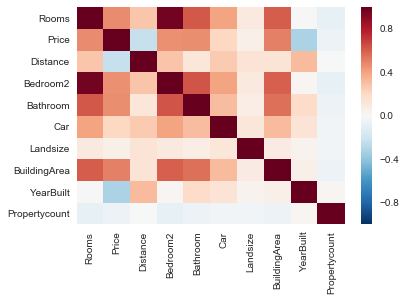

In [578]:
sns.heatmap(df.corr());

Only from the correlation matrix we see that the Price is mostly correlated with Rooms, Bedroom2, Bathroom, Car. But let's run another models to see if we can dig in for something interesting. 

Some features might be highly correlated, let's see what else can we do to make our model statistically compliant: 
- We have indeed a few very well correlated features between themselves, eg Rooms and Bedroom2 are showing pretty much the same thing. 
- The similar relation exist between Rooms and Bathroom or Building area. 
- We'll leave Bathroom and Building size because we're interested to see if the model will signal us something about them eg one of them is not significant.

Since we first need to understand which features are significant for our modeling, we'll use statsmodel package for the significance and also try tune in our model better usuing LASSO regression.

In [579]:
X = X.drop(['Bedroom2'], axis = 1)
len(X.columns)

19

We have 8887 observations and 19 features to build our regression model.

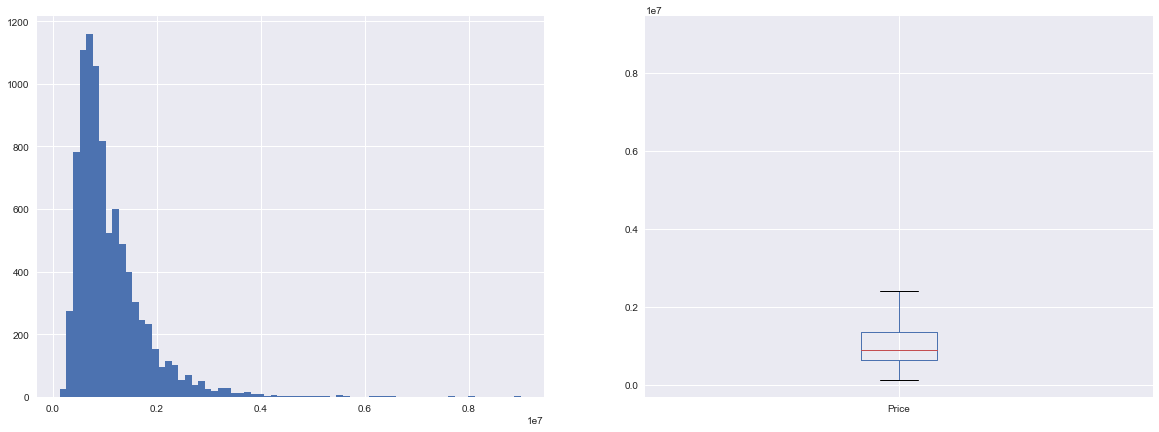

In [580]:
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1) 
Y.hist(bins = 70) 
plt.subplot(1, 2, 2) 
Y.plot.box()
plt.show()

The histogram looks like log normal or Gamma distribution (which we'll try to consider with the Gamma dist model further)

## 3. Training models and best model selection (together with feature selection)

### 3.1. Statsmodels: Simple Linear Model 

In [581]:
pd.options.display.float_format = '{:,.0f}'.format

lm = sm.OLS(Y, X)
lm = lm.fit()
print('R² for the model:')
print(lm.rsquared)
print('\nParameter estimates for the model with few features:') 
print(lm.summary())

R² for the model:
0.644454722488

Parameter estimates for the model with few features:
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     945.6
Date:                Sun, 27 May 2018   Prob (F-statistic):               0.00
Time:                        18:33:23   Log-Likelihood:            -1.2736e+05
No. Observations:                8887   AIC:                         2.548e+05
Df Residuals:                    8869   BIC:                         2.549e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------

#### 3.1.1 Residual analysis and outlier detection

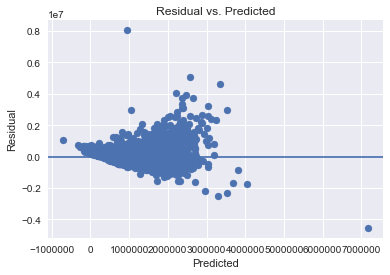

In [582]:
plt.scatter(lm.fittedvalues, lm.resid)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

There two residuals I'm worried about: at the far lower right corner and the upper left. We'll research about these two observations separately.

In [583]:
# how to identify which residual / predicted on the graph?

In [584]:
print('Maximum positive esidual (upper left courner):') 
print(lm.resid.nlargest(1))

print('\nMaximum negative Residual (lower right courner):') 
print(lm.resid.nsmallest(1))

Maximum positive esidual (upper left courner):
19583   8,053,751
dtype: float64

Maximum negative Residual (lower right courner):
2704   -4,553,707
dtype: float64


In [585]:
print('Potential outlier (Maximum negative residual):') 
print(df.loc[2704,:])

print('\nPotential outlier (Maximum positive residual):') 
print(df.loc[19583,:])

Potential outlier (Maximum negative residual):
Rooms                                5
Type                                 h
Price                        2,608,000
Distance                             8
Bedroom2                             5
Bathroom                             2
Car                                  4
Landsize                           730
BuildingArea                     3,112
YearBuilt                        1,920
Regionname       Southern Metropolitan
Propertycount                    8,920
Name: 2704, dtype: object

Potential outlier (Maximum positive residual):
Rooms                                     3
Type                                      h
Price                             9,000,000
Distance                                 19
Bedroom2                                  3
Bathroom                                  1
Car                                       1
Landsize                                744
BuildingArea                            117
YearBuilt      

In [586]:
# How do I test if it's out of range?
df.describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount
count,"8,887","8,887","8,887","8,887","8,887","8,887","8,887","8,887","8,887","8,887"
mean,3,"1,092,902",11,3,2,2,523,149,"1,966","7,476"
std,1,"679,382",7,1,1,1,"1,061",88,37,"4,375"
min,1,"131,000",0,0,1,0,0,0,"1,196",249
25%,2,"641,000",6,2,1,1,212,100,"1,945","4,382"
50%,3,"900,000",10,3,2,2,478,132,"1,970","6,567"
75%,4,"1,345,000",14,4,2,2,652,180,"2,000","10,331"
max,12,"9,000,000",47,12,9,10,"42,800","3,112","2,019","21,650"


- 2704th observation definitely looks odd: 

It's a house with 5 rooms and incredibly huge building size (3,112), which is the maximum building size in the data set. The building size is not even close to 75 percentile, so we can classify it as an outlier. In a real business case analysis it's worth investigating how this number occured and why the price was so low for this house in case the data is correct. 

- 19583rd observation looks odd too: 

From the available data it's a very ordinary house with 3 rooms, 1 not big garage, 1 bathroom, quite far from the city center. All the features of this house are lower the median for each of the features. The price on the other side, is above the sky. We'll classify it as the outlier as we cannot explain such high price from ou


In [587]:
df_dum = df_dum.drop([2704, 19583], axis = 0)
df = df.drop([2704, 19583], axis = 0)

We also see that there're some extreme values in variables Landsize (42,800	) and YearBuilt (1,196), we'll see if removing them increases our explanatory power. As real estate agents we'll ask somebody specialised at the mansions to estimate prices for houses with enormous land size.

In [588]:
print(df_dum.Landsize.nlargest(5))
print(df_dum.YearBuilt.nsmallest(2))

34055   42,800
28694   40,469
15109   37,000
13462   21,715
24413   21,600
Name: Landsize, dtype: float64
16424   1,196
3533    1,830
Name: YearBuilt, dtype: float64


In [589]:
df_dum = df_dum.drop([34055, 16424, 28694, 15109], axis = 0)
df = df.drop([34055, 16424, 28694, 15109], axis = 0)

In [590]:
df.describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount
count,"8,881","8,881","8,881","8,881","8,881","8,881","8,881","8,881","8,881","8,881"
mean,3,"1,091,883",11,3,2,2,510,149,"1,966","7,477"
std,1,"674,187",7,1,1,1,772,82,36,"4,375"
min,1,"131,000",0,0,1,0,0,0,"1,830",389
25%,2,"641,000",6,2,1,1,212,100,"1,945","4,385"
50%,3,"900,000",10,3,2,2,477,132,"1,970","6,567"
75%,4,"1,345,000",14,4,2,2,652,180,"2,000","10,331"
max,12,"8,000,000",47,12,9,10,"21,715","1,561","2,019","21,650"


We'll also remove the Propertycount feature, as it's not statistically significant and we'll run the model again without the outliers. 

#### 3.1.2 Statsmodels: Simple Linear Model - Second Iteration

In [591]:
X = df_dum.drop(['Price','Bedroom2', 'Propertycount'], axis = 1)
Y = df_dum['Price']

In [592]:
lm = sm.OLS(Y, X)
lm = lm.fit()
print('R² for the model:')
print(lm.rsquared)
print('\nParameter estimates for the model with few features:') 
print(lm.params)

R² for the model:
0.663096710478

Parameter estimates for the model with few features:
Rooms                                     102,968
Distance                                  -37,645
Bathroom                                  171,359
Car                                        49,339
Landsize                                       33
BuildingArea                                2,125
YearBuilt                                  -3,599
Type_h                                  5,666,589
Type_t                                  5,524,334
Type_u                                  5,316,523
Regionname_Eastern Metropolitan         2,019,757
Regionname_Eastern Victoria             2,325,376
Regionname_Northern Metropolitan        1,795,172
Regionname_Northern Victoria            2,134,817
Regionname_South-Eastern Metropolitan   2,206,068
Regionname_Southern Metropolitan        2,275,348
Regionname_Western Metropolitan         1,731,352
Regionname_Western Victoria             2,019,556
dtype: float6

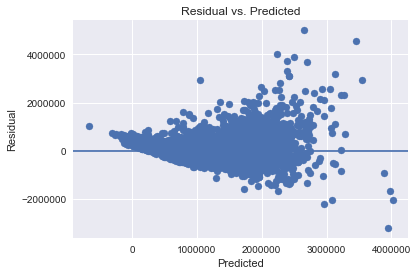

In [593]:
plt.scatter(lm.fittedvalues, lm.resid)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Most impactful features for the price sensitivity so far are (in the order of price contribution): 
1. type of the property: 
 - house are valued more than townhouses
 - in turn, townhouses are more prestige than flats
2. location: 
 - house in Eastern Victoria or Southern Metropolitan are more highly priced.
 - the 'worst' region in terms of price will be Western Metropolitan or Northern Metropolitan 
3. rooms: 
 - Second bathroom is quite an important contributor, I guess because it adds  convenience and prestige.
 - Bedrooms are less important than rooms.
 - A garage is less important and contributes significantly less than bathroom or other rooms, but still adds some value. 

#### 3.1.3 Using Statsmodel with C (categorical) parameter to avoid  get_dummies trap

##### Additional questions:
- How should we interpret the intercept? Also, it's missing here. 
- If all the categorical variables are in the features. 
- We'll use another built-in functionality in statsmodels that allows to incorporate easily categorical features.

In [594]:
linear_formula = 'Price ~ Rooms + C(Type) + Distance + Bathroom + Car + Landsize + BuildingArea + YearBuilt + C(Regionname)'
lm = smf.ols(formula=linear_formula, data=df).fit() 
print('R² for the model:')
print(lm.rsquared);
print('\nParameter estimates for the model with few features:') 
print(lm.params);

R² for the model:
0.663096710478

Parameter estimates for the model with few features:
Intercept                                     7,686,346
C(Type)[T.t]                                   -142,256
C(Type)[T.u]                                   -350,066
C(Regionname)[T.Eastern Victoria]               305,619
C(Regionname)[T.Northern Metropolitan]         -224,585
C(Regionname)[T.Northern Victoria]              115,060
C(Regionname)[T.South-Eastern Metropolitan]     186,311
C(Regionname)[T.Southern Metropolitan]          255,592
C(Regionname)[T.Western Metropolitan]          -288,405
C(Regionname)[T.Western Victoria]                  -200
Rooms                                           102,968
Distance                                        -37,645
Bathroom                                        171,359
Car                                              49,339
Landsize                                             33
BuildingArea                                      2,125
YearBuilt        

### 3.1.4. From the Statsmodel's linear model we can conclude: 

##### The location is much more important than rooms than number of rooms. 
The difference between the 'best' and the 'worst' location is about 590,000 dollars. If we have 2 exactly similar houses in those locations, it will cost about 6 rooms to be added in order to compensate for this difference. 

##### The house type is again more important than rooms.
The difference between a house and a flat is about 360,000 dollars. Only a huge flat with an 2 additional rooms and an additional bathroom can compensate for this.

Based on this observation, a separate house in Southern Metropolitan or Eastern Victoria region looks like the dream for real estate agent and houseowners. 

##### About Other features: 
##### Land size doesn't seem to be important in comparison with building size. 
Mean for the building size is 149 across the dataset. If we multiply the mean by the coefficient, we get 317,000 dollars increase, which is quite significant price contribution. 
For the land size, the mean is 477. Once this is multiplied by the Landsize coefficient, we only get 16,000 dollars increase, which is way less than achieved by the building size.

##### Yearbuilt is important to consider when we're comparing very old houses with very new ones.
We assume that the houses we'll mostly see will have a difference about 70 years at most, this will constitute about 252,000 dollars. This is significant, when we deal with old vs new house. To put things on scale, this difference can be compensated by either better location OR additional room and bathroom. 

### [Need more information] 3.2. Statsmodels : Generalized Linear Model with Gamma disctribution

In [595]:
gamma_model = sm.GLM(Y, X, family=sm.families.Gamma())
gamma_results = gamma_model.fit()
gamma_results.summary()

/Users/polinav/anaconda/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:244: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Price   No. Observations:                 8881
Model:                            GLM   Df Residuals:                     8864
Model Family:                   Gamma   Df Model:                           16
Link Function:          inverse_power   Scale:                  0.092806898957
Method:                          IRLS   Log-Likelihood:            -1.3272e+05
Date:                Sun, 27 May 2018   Deviance:                       2358.0
Time:                        18:33:24   Pearson chi2:                     823.
No. Iterations:                     8                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Rooms                                 -8.843e-08   1.92e-09    -46.096      0.000   -9.22e-08   -8.47e-08
Distance                                3.65e-08   6.46e-10     56.482      0.000    3.52e-08    3.78e-08
Bathroom                              -6.203e-08   1.88e-09    -33.067      0.000   -6.57e-08   -5.84e-08
Car                                   -4.413e-08   1.67e-09    -26.430      0.000   -4.74e-08   -4.09e-08
Landsize                              -3.899e-11   3.14e-12    -12.429      0.000   -4.51e-11   -3.28e-11
BuildingArea                          -9.553e-10   1.51e-11    -63.471      0.000   -9.85e-10   -9.26e-10
YearBuilt                               1.69e-09   4.88e-11     34.653      0.000    1.59e-09    1.79e-09
Type_h                                -1.597e-06   6.55e-08    -24.397      0.000   -1.73e-06   -1.47e-06
Type_t                                -1.492e-06   6.91e-08    -21.578      0.000   -1.63e-06   -1.36e-06
Type_u                                -9.412e-07   6.94e-08    -13.567      0.000   -1.08e-06   -8.05e-07
Regionname_Eastern Metropolitan       -6.337e-07   2.96e-08    -21.375      0.000   -6.92e-07   -5.76e-07
Regionname_Eastern Victoria           -7.853e-07   6.33e-08    -12.406      0.000   -9.09e-07   -6.61e-07
Regionname_Northern Metropolitan      -3.752e-07   3.07e-08    -12.240      0.000   -4.35e-07   -3.15e-07
Regionname_Northern Victoria          -4.536e-07   6.63e-08     -6.845      0.000   -5.84e-07   -3.24e-07
Regionname_South-Eastern Metropolitan -7.961e-07   3.15e-08    -25.242      0.000   -8.58e-07   -7.34e-07
Regionname_Southern Metropolitan      -7.072e-07   2.97e-08    -23.812      0.000   -7.65e-07   -6.49e-07
Regionname_Western Metropolitan       -3.437e-07    3.1e-08    -11.096      0.000   -4.04e-07   -2.83e-07
Regionname_Western Victoria            6.493e-08   9.72e-08      0.668      0.504   -1.25e-07    2.55e-07
=========================================================================================================
"""

### 3.3. LASSO regression: feature selection based on it's coefficients

#### Statsmodels

In [596]:
# how to build lasso with statsmodels?
# sm.Logit(Y, X, data=df)

#### SKlearn

In [597]:
lass = Lasso(alpha=100)
lassfit = lass.fit(X, Y)
print('R² for the model:')
print(lass.score(X, Y))

# Coef table:
lass_param = np.append(lass.coef_, lass.intercept_)
titles = X.columns
titles = titles.tolist()
titles.append('Intercept')
features_coef=pd.DataFrame(data=lass_param, index = titles,columns=['Coefficient'])

print('\nParameter estimates from the LASSO model:') 
features_coef

R² for the model:
0.663082298024

Parameter estimates from the LASSO model:


,Coefficient
Rooms,"102,753"
Distance,"-37,442"
Bathroom,"171,411"
Car,"49,179"
Landsize,33
BuildingArea,"2,130"
YearBuilt,"-3,612"
Type_h,"141,417"
Type_t,0
Type_u,"-206,940"


##### Conclusion from the LASSO model: 
No numerical features set to zero. Numerical features with Lasso generally follow the same pattern as with linear model we built before, so we'll stick to our previous conclusion.

# Potential future research (outside of the task)

## 4. What if we try feature transformation

### 4.1. Identifying which features to transform

In [598]:
feature_df = df.drop(['Price','Bedroom2', 'Propertycount'], axis = 1)
num_feature_df = feature_df.drop(['Regionname','Type'], axis = 1)

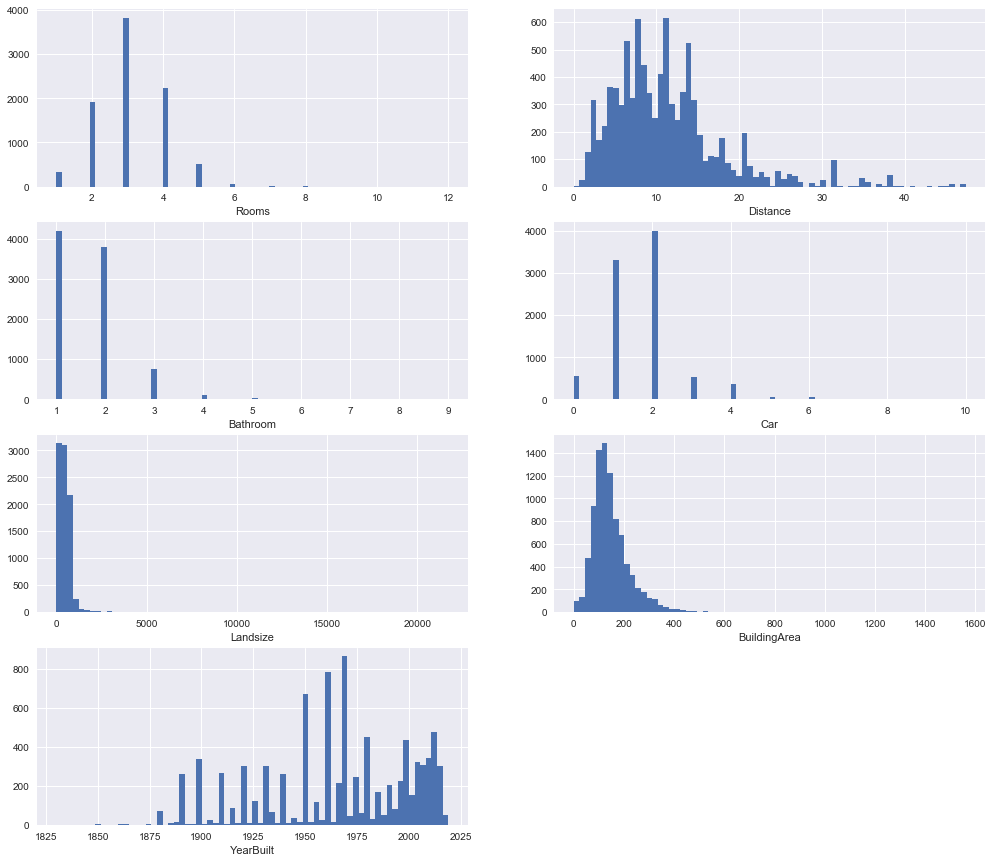

In [599]:
plt.figure(figsize=(17,15))
n=0
for column in num_feature_df.columns:
    n+=1
    plt.subplot(4, 2, n) 
    num_feature_df[column].hist(bins = 70)
    plt.xlabel(column)

plt.show()

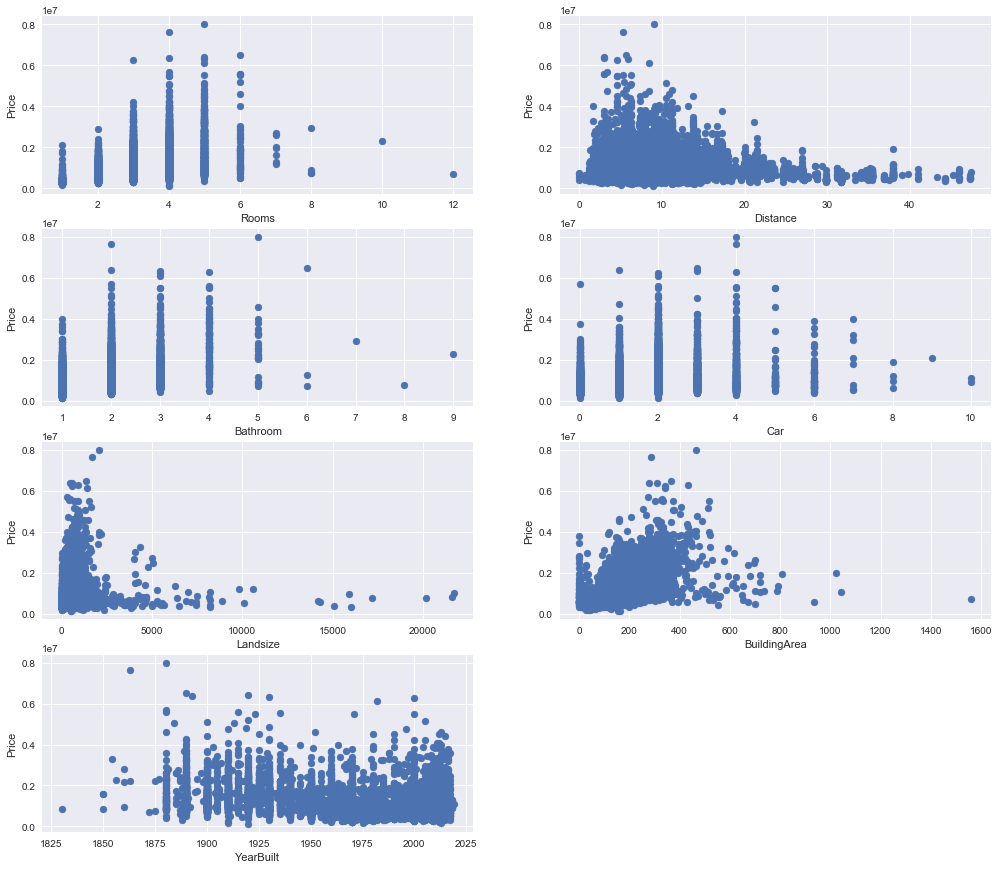

In [606]:
plt.figure(figsize=(17,15))
n=0
for column in num_feature_df.columns:
    n+=1
    plt.subplot(4, 2, n) 
    plt.scatter(x=num_feature_df[column], y=df['Price'])
    plt.ylabel('Price')
    plt.xlabel(column)


plt.show()

What can we tell from these graphs?

## Code Depository

In [600]:
# print('Cross validation: ' + str(cross_val_score(RandomForestClassifier(), X, Y, cv=5)))

In [601]:
print('Maximum Residual (upper left courner):') 
print(lm.resid.max())
print('Index of observation with the suspect residual:') 
print(lm.resid.argmax())

print('\nMinimum Residual (lower right courner):') 
print(lm.resid.min())
print('Index of observation with the suspect residual:') 
print(lm.resid.argmin())

Maximum Residual (upper left courner):
5000311.52913
Index of observation with the suspect residual:
15696

Minimum Residual (lower right courner):
-3199873.1047
Index of observation with the suspect residual:
3780
